In [38]:
import sys, os
sys.path.append('../')
sys.path.append('../src/')

import torch
import numpy as np
import utils
from torch.nn import Module, Parameter
import torch.optim as opt
from utils import preprocess
import torch.nn.functional as F

import torch.optim as opt
from torch import softmax, log_softmax, Tensor
from sklearn.cluster import KMeans
from scipy.sparse.linalg import svds
import seaborn as sns
from scipy.spatial.distance import pdist, squareform
import random
from sklearn.decomposition import PCA
from umap import UMAP

import pandas as pd 
import numpy as np 
import scipy.sparse as sp
import torch
import model
import time

import quantile 

import coupleNMF as coupleNMF

from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


In [2]:
# read in dataset
dir = '../data/real/diag/BMMC/'

counts_rnas = []
counts_atacs = []
counts_proteins = []
for batch in [1, 2]:
    try:
        counts_atac = np.array(sp.load_npz(os.path.join(dir, 'RxC' + str(batch) + ".npz")).todense().T)
        counts_atac = utils.preprocess(counts_atac, modality = "ATAC")

    except:
        counts_atac = None
        
    try:
        counts_rna = np.array(sp.load_npz(os.path.join(dir, 'GxC' + str(batch) + ".npz")).todense().T)
        counts_rna = utils.preprocess(counts_rna, modality = "RNA")
    
    except:
        counts_rna = None
    
    # preprocess the count matrix
    counts_rnas.append(counts_rna)
    counts_atacs.append(counts_atac)

counts = {"rna":counts_rnas, "atac": counts_atacs}

A = sp.load_npz(os.path.join(dir, 'GxR.npz'))
A = np.array(A.todense())
interacts = {"rna_atac": A}


# obtain the feature name
genes = pd.read_csv(dir + "genes.txt", header = None).values.squeeze()
regions = pd.read_csv(dir + "regions.txt", header = None).values.squeeze()

feats_name = {"rna": genes, "atac": regions}
counts["feats_name"] = feats_name

In [3]:
#hyper parameters: best lr = 5e-3, T = 4000, latent_dims = 13
alpha = [1000, 1, 100, 100, 0.00]
batchsize = 0.3
run = 0
Ns = [8] * 2
K = 8
N_feat = Ns[0]
interval = 100
T = 5000
lr = 1e-2

In [4]:
# didn't use the interaction matrix
model1 = model.cfrm_new(counts = counts, interacts = None, Ns = Ns, K = K, N_feat = N_feat, batch_size = batchsize, interval = interval, lr = lr, alpha = alpha, seed = run).to(device)
losses1 = model1.train_func(T = T, T1 = None)

Input sanity check...
Finished.
Epoch 100, Validating Loss: -173.1001
	 loss 1: 26.89976
	 loss 2: 0.00000
	 loss 3: -199.99986
	 loss 4: 0.00000
	 loss 5: 0.00000
Epoch 200, Validating Loss: -173.1976
	 loss 1: 26.80206
	 loss 2: 0.00000
	 loss 3: -199.99962
	 loss 4: 0.00000
	 loss 5: 0.00000
Epoch 300, Validating Loss: -173.7778
	 loss 1: 26.22196
	 loss 2: 0.00000
	 loss 3: -199.99976
	 loss 4: 0.00000
	 loss 5: 0.00000
Epoch 400, Validating Loss: -173.9695
	 loss 1: 26.03033
	 loss 2: 0.00000
	 loss 3: -199.99988
	 loss 4: 0.00000
	 loss 5: 0.00000
Epoch 500, Validating Loss: -174.2277
	 loss 1: 25.77211
	 loss 2: 0.00000
	 loss 3: -199.99983
	 loss 4: 0.00000
	 loss 5: 0.00000
Epoch 600, Validating Loss: -174.3305
	 loss 1: 25.66930
	 loss 2: 0.00000
	 loss 3: -199.99983
	 loss 4: 0.00000
	 loss 5: 0.00000
Epoch 700, Validating Loss: -174.3882
	 loss 1: 25.61163
	 loss 2: 0.00000
	 loss 3: -199.99986
	 loss 4: 0.00000
	 loss 5: 0.00000
Epoch 800, Validating Loss: -174.4436
	 loss

In [5]:
# assigning cell clusters and gene clusters
model1.assign_clusters(n_relocate = None)


assigning cell clusters...
assigning feature clusters...
binarizing association matrix...


In [6]:
zs = []
labels = []
prec_labels = []
pre_labels = []
for batch in range(0,2):
    z = model1.softmax(model1.C_cells[batch].cpu().detach()).numpy()
    # z = model1.C_cells[batch].cpu().detach().numpy()
    zs.append(z)
    labels.append(pd.read_csv(os.path.join(dir, 'meta_c' + str(batch + 1) + '.csv'), index_col=0)["cluster"].values.squeeze())
    pre_labels.append(np.argmax(z, axis = 1).squeeze())
    
umap_op = UMAP(n_components = 2, n_neighbors = 15, min_dist = 0.4, random_state = 0) 
x_umap = umap_op.fit_transform(np.concatenate(zs, axis = 0))
# separate into batches
x_umaps = []
for batch in range(0,2):
    if batch == 0:
        start_pointer = 0
        end_pointer = start_pointer + zs[batch].shape[0]
        x_umaps.append(x_umap[start_pointer:end_pointer,:])
    elif batch == 3:
        start_pointer = start_pointer + zs[batch - 1].shape[0]
        x_umaps.append(x_umap[start_pointer:,:])
    else:
        start_pointer = start_pointer + zs[batch - 1].shape[0]
        end_pointer = start_pointer + zs[batch].shape[0]
        x_umaps.append(x_umap[start_pointer:end_pointer,:])

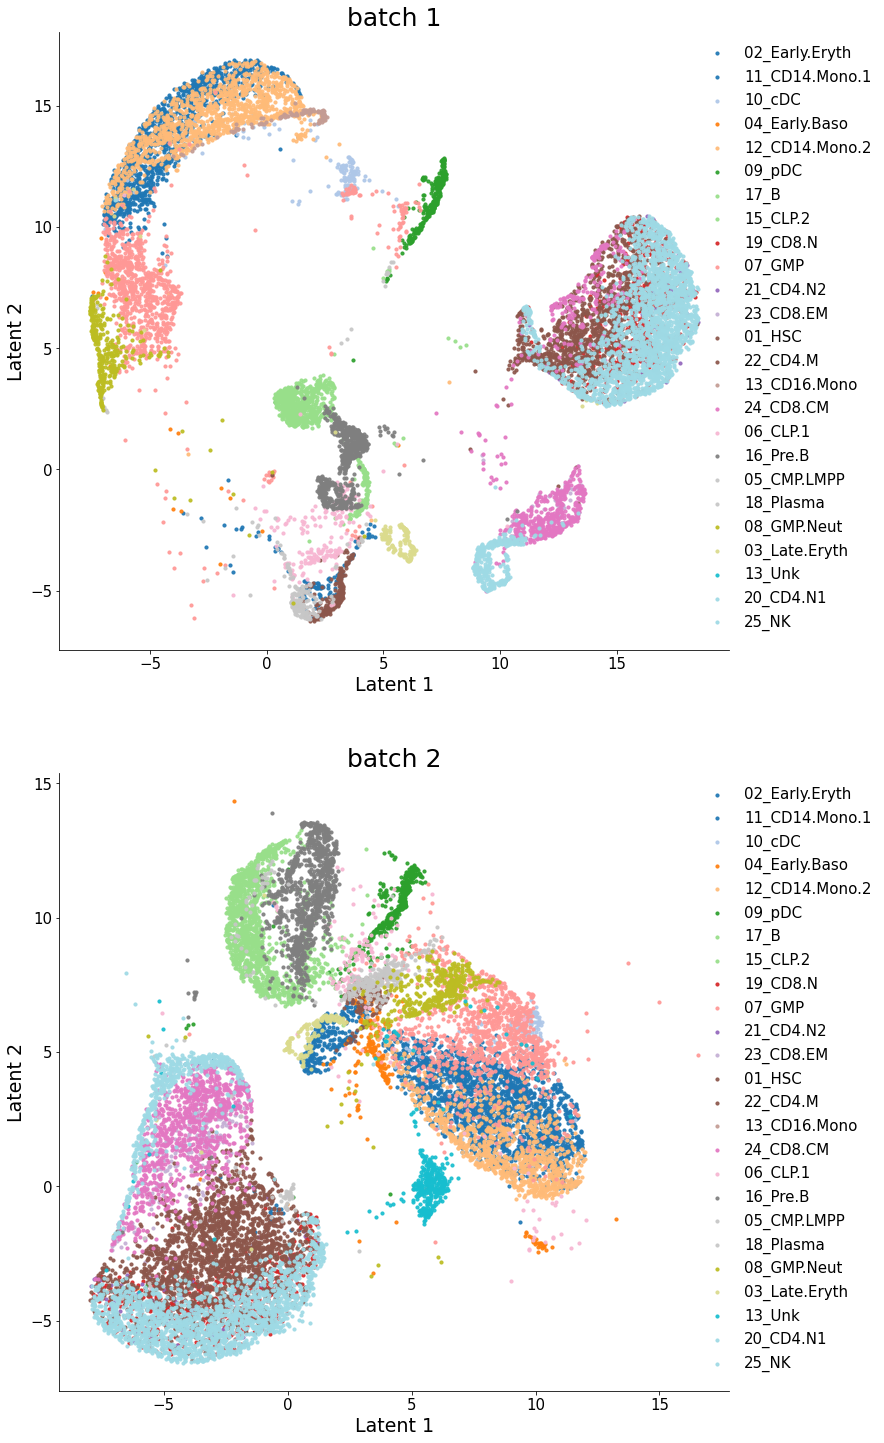

In [7]:
# utils.plot_latent_ext(x_umaps, annos = prec_labels, mode = "separate", save = None, figsize = (10,30), axis_label = "Latent")
utils.plot_latent_ext(x_umaps, annos = labels, mode = "separate", save = None, figsize = (12,25), axis_label = "Latent")


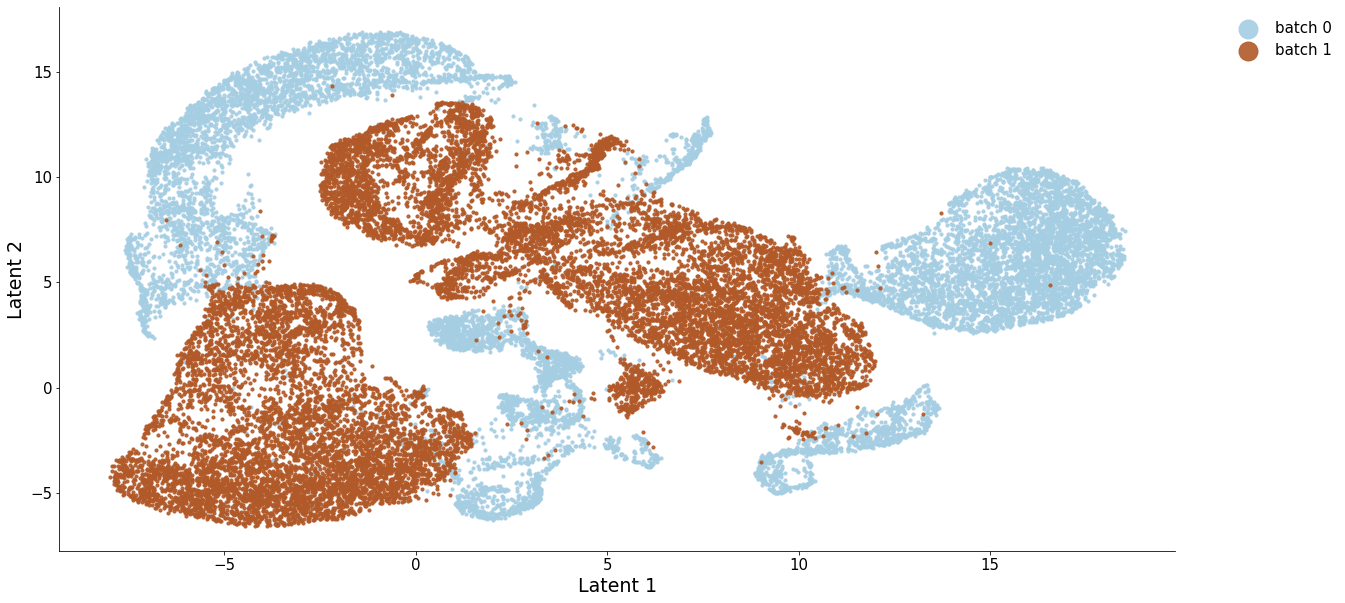

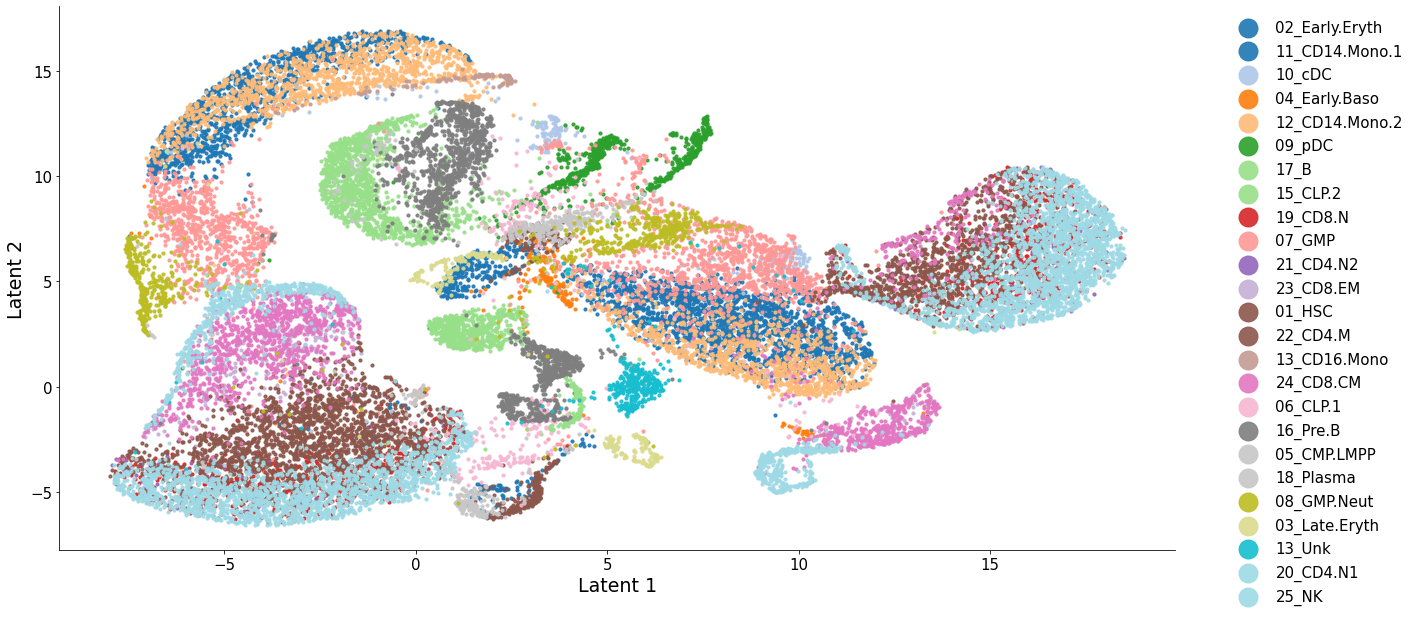

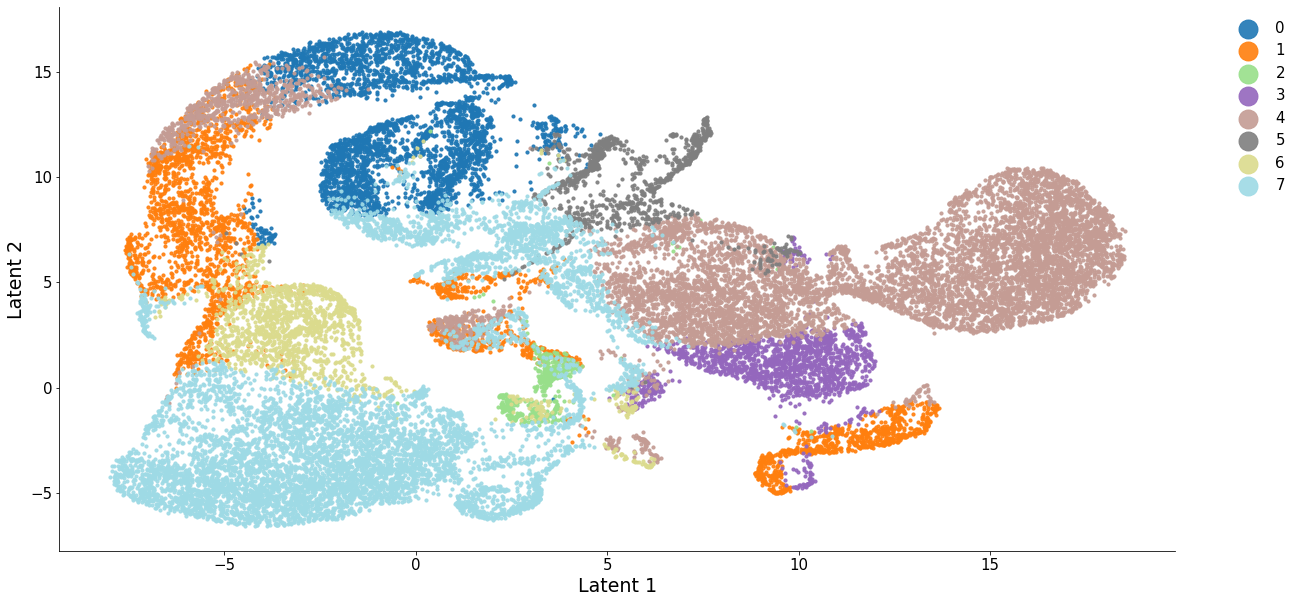

In [8]:
utils.plot_latent_ext(x_umaps, annos = labels, mode = "modality", save = None, 
                      figsize = (20,10), axis_label = "Latent", markerscale = 6)

utils.plot_latent_ext(x_umaps, annos = labels, mode = "joint", save = None, 
                      figsize = (20,10), axis_label = "Latent", markerscale = 6)

utils.plot_latent_ext(x_umaps, annos = pre_labels, mode = "joint", save = None, 
                      figsize = (20,10), axis_label = "Latent", markerscale = 6)


# Modify

In [19]:
zs = []
labels = []
prec_labels = []
pre_labels = []
for batch in range(0,2):
    z = model1.softmax(model1.C_cells[batch].cpu().detach()).numpy()
    # z = model1.C_cells[batch].cpu().detach().numpy()
    zs.append(z)
    labels.append(pd.read_csv(os.path.join(dir, 'meta_c' + str(batch + 1) + '.csv'), index_col=0)["cluster"].values.squeeze())
    pre_labels.append(np.argmax(z, axis = 1).squeeze())

In [10]:
# get a pairwise distance matrix
pair_dist = squareform(pdist(np.concatenate(zs, axis=0)))

# get the matrix who has the largest numbers of elements as the reference matrix
start_point, end_point = [], []
maxnum, maxbatch, start, number = 0, 0, 0, 0

for batch in range(len(zs)):
    start_point.append(start)
    number = len(zs[batch])
    start += number
    end = start-1
    end_point.append(end)
    if number > maxnum:
        maxnum = start
        maxbatch = batch

# regard the largest matrix as the reference matrix
ref_dis = pair_dist[start_point[maxbatch]:end_point[maxbatch]+1, start_point[maxbatch]:end_point[maxbatch]+1].flatten()


# get the list of No.batch needed to be modified
mod_batch = list(range(len(zs)))
mod_batch.remove(maxbatch)

In [11]:
pre_mean = np.zeros((len(zs), len(zs)))

for row in range(len(zs)):
    for col in range(len(zs)):
        block = pair_dist[start_point[row]:end_point[row]+1, start_point[col]:end_point[col]+1]
        mean = np.mean(block)
        pre_mean[row, col] = mean

In [12]:
# Modify other blocks
i = 0
for rows in range(len(zs)):
    for batch in range(i, len(zs)):
        if [rows, batch] == [maxbatch, maxbatch]:
            i += 1
            continue
        else:
            blo = pair_dist[start_point[rows]:end_point[rows]+1, start_point[batch]:end_point[batch]+1]
            d = dict(enumerate(blo.flatten()))
            d_sort = sorted(d.items(), key=lambda x: x[1])

            sample = random.sample(list(ref_dis.flatten()), len(d_sort))
            sample.sort()

            j = 0
            for j in range(len(d)):
                key = d_sort[j][0]
                d[key] = sample[j]

            arr = np.array(list(d.values())).reshape(blo.shape)
            pair_dist[start_point[rows]:end_point[rows]+1, start_point[batch]:end_point[batch]+1] = arr
            pair_dist[start_point[batch]:end_point[batch]+1, start_point[rows]:end_point[rows]+1] = np.transpose(arr)
            i += 1

np.fill_diagonal(pair_dist, 0)

In [13]:
aft_mean = np.zeros((len(zs), len(zs)))

for row in range(len(zs)):
    for col in range(len(zs)):
        block = pair_dist[start_point[row]:end_point[row]+1, start_point[col]:end_point[col]+1]
        mean = np.mean(block)
        aft_mean[row, col] = mean

In [14]:
pre_mean

array([[0.25997222, 0.32671694],
       [0.32671694, 0.32840824]])

In [15]:
aft_mean

array([[0.32839511, 0.32841447],
       [0.32841447, 0.32840824]])

/ocean/projects/cis210014p/xchen786/.conda/envs/pytorch/lib/python3.7/site-packages/umap/umap_.py:1736: UserWarning: using precomputed metric; transform will be unavailable for new data and inverse_transform will be unavailable for all data
  "using precomputed metric; transform will be unavailable for new data and inverse_transform "


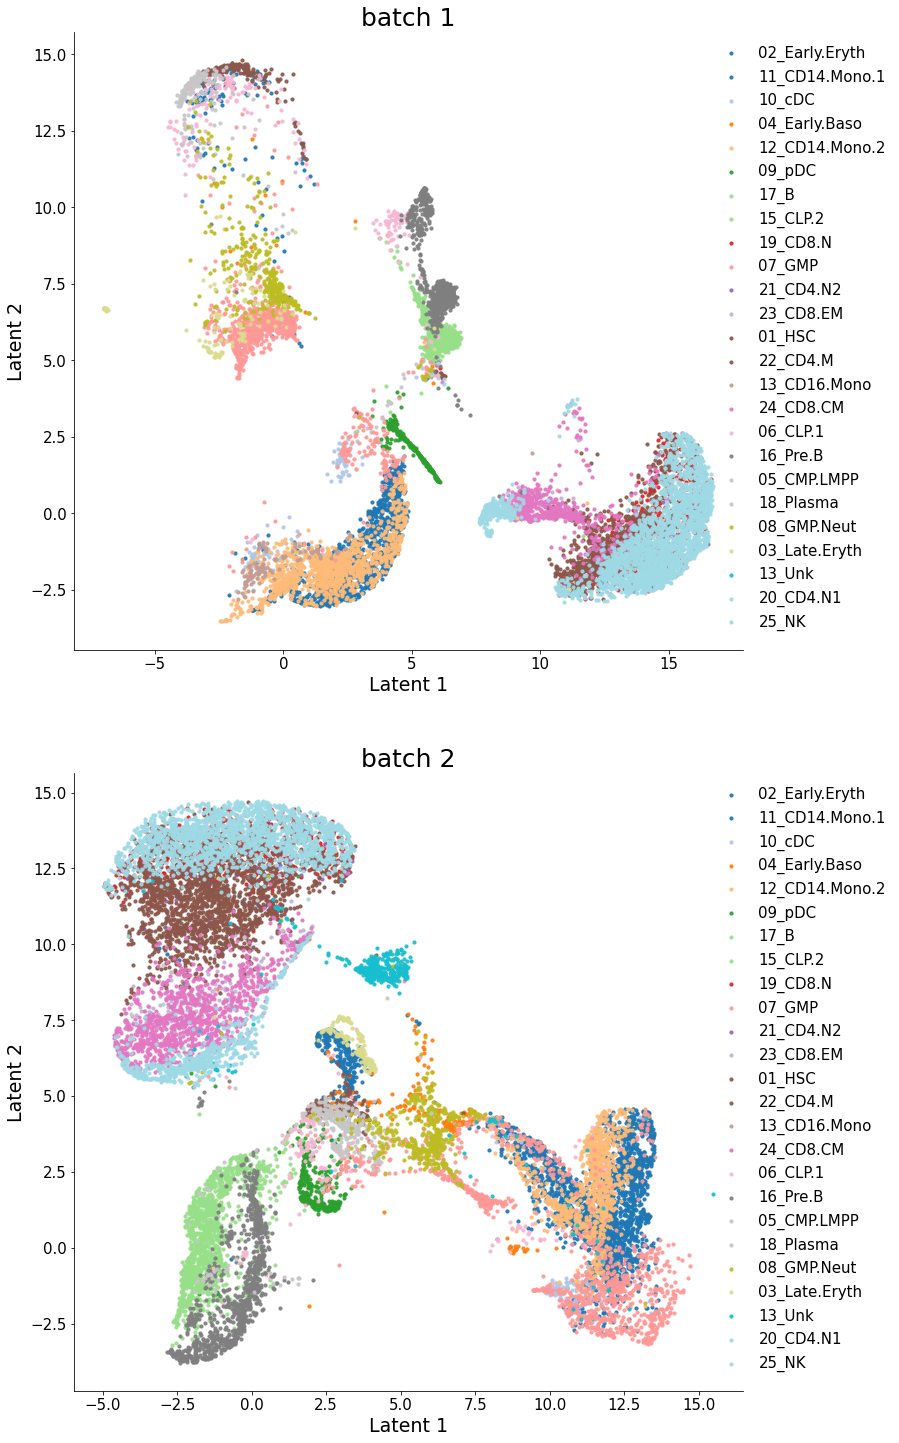

In [39]:
umap_op = UMAP(n_components = 2, n_neighbors = 20, min_dist = 0.3, random_state = 0, metric='precomputed') 
x_umap = umap_op.fit_transform(pair_dist)
# separate into batches
x_umaps = []
for batch in range(0,2):
    if batch == 0:
        start_pointer = 0
        end_pointer = start_pointer + zs[batch].shape[0]
        x_umaps.append(x_umap[start_pointer:end_pointer,:])
    elif batch == 3:
        start_pointer = start_pointer + zs[batch - 1].shape[0]
        x_umaps.append(x_umap[start_pointer:,:])
    else:
        start_pointer = start_pointer + zs[batch - 1].shape[0]
        end_pointer = start_pointer + zs[batch].shape[0]
        x_umaps.append(x_umap[start_pointer:end_pointer,:])

# utils.plot_latent_ext(x_umaps, annos = prec_labels, mode = "separate", save = None, figsize = (10,30), axis_label = "Latent")
utils.plot_latent_ext(x_umaps, annos = labels, mode = "separate", save = None, figsize = (20,25), axis_label = "Latent")


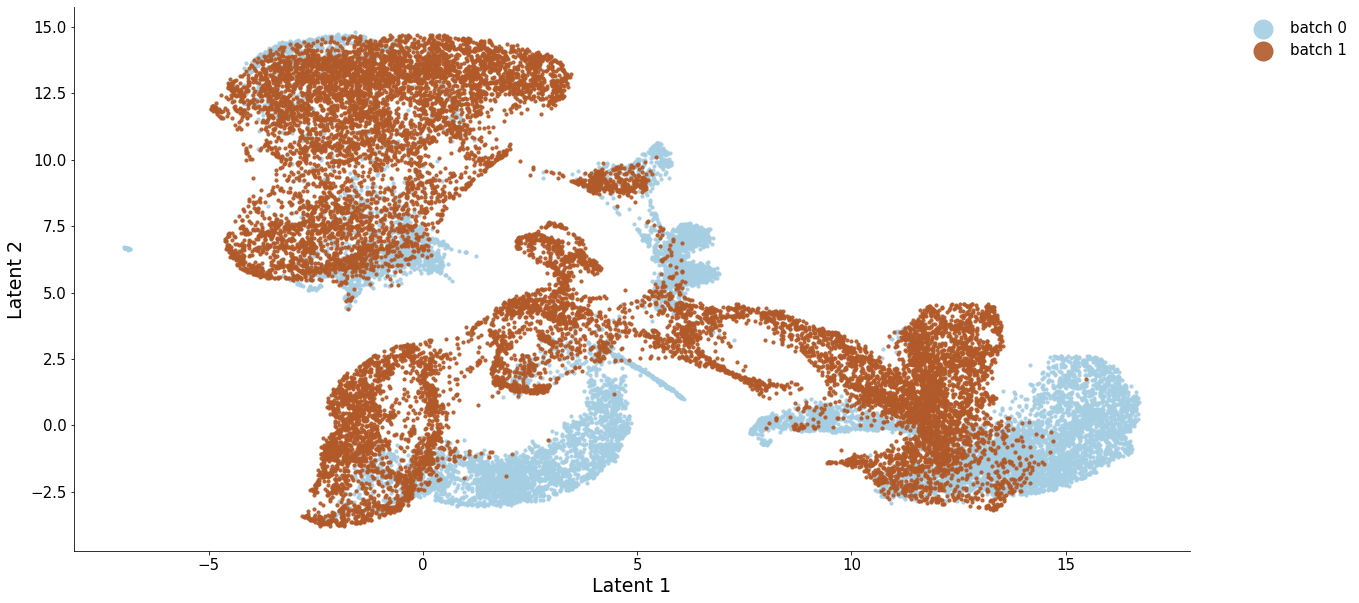

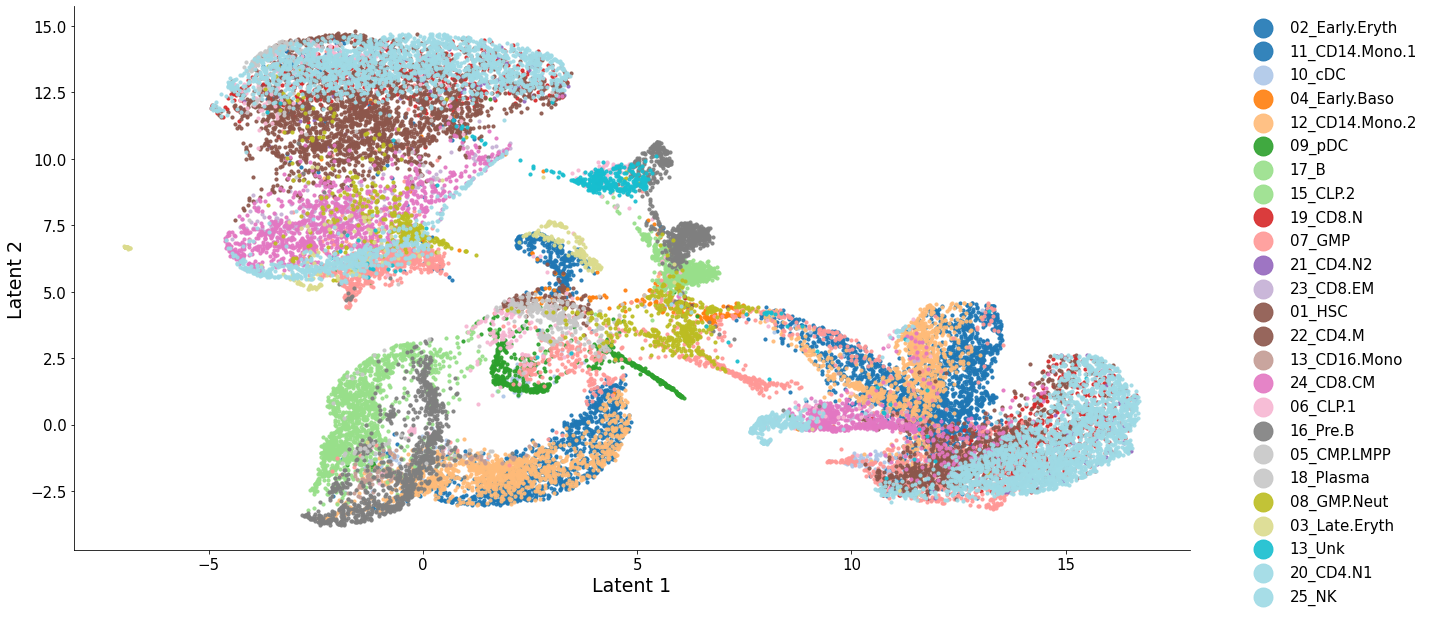

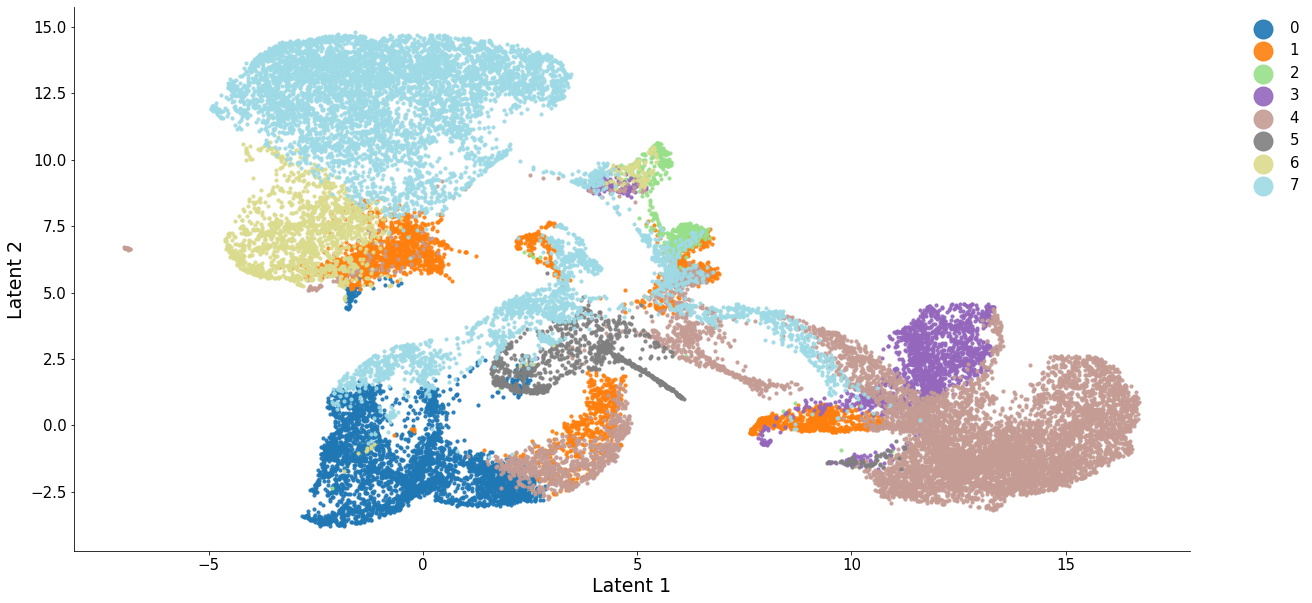

In [40]:
utils.plot_latent_ext(x_umaps, annos = labels, mode = "modality", save = None, 
                      figsize = (20,10), axis_label = "Latent", markerscale = 6)

utils.plot_latent_ext(x_umaps, annos = labels, mode = "joint", save = None, 
                      figsize = (20,10), axis_label = "Latent", markerscale = 6)

utils.plot_latent_ext(x_umaps, annos = pre_labels, mode = "joint", save = None, 
                      figsize = (20,10), axis_label = "Latent", markerscale = 6)
